# AFTER: Annotated Forbush–decrease Topological Event Recognition 🎯

## Results analysis...

### **1. Imports and load AFTER catalogs from CSV**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- 1. Load single-station AFTER (formerly "sierra") events ---

event_date_cols = ["onset_time", "min_time", "rec_time"]

events_strict = pd.read_csv(
    "Results/sierra_events_strict.csv",
    parse_dates=event_date_cols
)

events_medium = pd.read_csv(
    "Results/sierra_events_medium.csv",
    parse_dates=event_date_cols
)

events_loose = pd.read_csv(
    "Results/sierra_events_loose.csv",
    parse_dates=event_date_cols
)

# Ensure timezone-naive datetimes (if any tz is present)
for df_ev in [events_strict, events_medium, events_loose]:
    for col in event_date_cols:
        if col in df_ev.columns and pd.api.types.is_datetime64tz_dtype(df_ev[col]):
            df_ev[col] = df_ev[col].dt.tz_convert(None)

/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_17183/1399861102.py:23: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if col in df_ev.columns and pd.api.types.is_datetime64tz_dtype(df_ev[col]):


In [3]:
# --- 2. Load multi-station coincidence tables --

coinc_strict = pd.read_csv(
    "Results/sierra_coincidences_strict.csv",
    parse_dates=["repr_time"]
)
coinc_medium = pd.read_csv(
    "Results/sierra_coincidences_medium.csv",
    parse_dates=["repr_time"]
)
coinc_loose = pd.read_csv(
    "Results/sierra_coincidences_loose.csv",
    parse_dates=["repr_time"]
)

for df_c in [coinc_strict, coinc_medium, coinc_loose]:
    if pd.api.types.is_datetime64tz_dtype(df_c["repr_time"]):
        df_c["repr_time"] = df_c["repr_time"].dt.tz_convert(None)

/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_17183/4206961957.py:17: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df_c["repr_time"]):


In [4]:
# --- 3. Load AFTER-M 2019 catalog (Medium + drop >= 1.5%, with quality, matched_izmiran, etc.) ---

AFTER_M_2019 = pd.read_csv(
    "Results/sierra_M_2019_catalog.csv",
    parse_dates=["repr_time"]
)
if pd.api.types.is_datetime64tz_dtype(AFTER_M_2019["repr_time"]):
    AFTER_M_2019["repr_time"] = AFTER_M_2019["repr_time"].dt.tz_convert(None)

AFTER_M_2019.head()

/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_17183/1336418389.py:7: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(AFTER_M_2019["repr_time"]):


,repr_time,n_stations,stations,drop_mean,drop_max,A_complex_mean,A_complex_max,quality,matched_izmiran
0,2019-01-02 02:20:00,2,"DOMC,NEWK",5.433584,6.278327,4.571568,7.132827,B,False
1,2019-01-03 12:34:00,3,"APTY,INVK,NEWK",3.139465,4.432143,4.222290,4.563575,A,True
2,2019-01-05 02:40:00,2,"DOMC,JUNG1",5.214218,7.477309,4.599107,5.685916,B,True
3,2019-01-05 23:20:00,2,"JUNG1,MXCO",3.102612,3.223963,8.073693,11.275951,B,False
4,2019-01-06 23:21:00,3,"AATB,KERG,NEWK",3.214571,4.929425,5.967089,9.484482,A,False


In [5]:
# --- 4. Load IZMIRAN 2019 catalog with AFTER flags ---

AFTER_izmiran_2019 = pd.read_csv(
    "Results/izmiran_2019_with_sierra_flags.csv",
    parse_dates=["t_izmiran"]
)

if "t_izmiran" in AFTER_izmiran_2019.columns and \
   pd.api.types.is_datetime64tz_dtype(AFTER_izmiran_2019["t_izmiran"]):
    AFTER_izmiran_2019["t_izmiran"] = AFTER_izmiran_2019["t_izmiran"].dt.tz_convert(None)

AFTER_izmiran_2019.head()

/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_17183/3015607375.py:9: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  pd.api.types.is_datetime64tz_dtype(AFTER_izmiran_2019["t_izmiran"]):


,Date of event,MagnM,Axym,Azrange,TminM,DminM,OType,Bmax,Bzmin,Vmax,Dstmin,t_izmiran,in_sierra_M,sierra_qualities
0,2019.01.04 12:00:00,1.4,1.01,0.80,62,-0.19,9,11.4,-7.1,554.0,-23.0,2019-01-04 12:00:00,True,"A,B"
1,2019.01.10 14:00:00,0.6,0.82,0.65,14,-0.23,9,7.3,-3.0,509.0,-9.0,2019-01-10 14:00:00,True,B
2,2019.01.13 01:00:00,0.4,0.84,0.50,10,-0.15,9,3.4,-2.0,366.0,-4.0,2019-01-13 01:00:00,True,B
3,2019.01.13 23:00:00,0.5,1.06,0.70,2,-0.27,9,10.2,-3.8,403.0,-2.0,2019-01-13 23:00:00,True,"A,B"
4,2019.01.15 11:00:00,0.4,1.06,0.57,15,-0.19,9,7.7,-2.6,417.0,-7.0,2019-01-15 11:00:00,True,A


In [6]:
# --- 5. AFTER dictionaries for convenience (by level) ---

AFTER_events_by_level = {
    "strict": events_strict,
    "medium": events_medium,
    "loose":  events_loose,
}

AFTER_coinc_by_level = {
    "strict": coinc_strict,
    "medium": coinc_medium,
    "loose":  coinc_loose,
}

### **2. Summary table per year and per AFTER level**
Good candidate for Table 1: how many events and matches there are per year and level.

In [7]:
summary_rows = []

for level_name, ev in AFTER_events_by_level.items():
    ev = ev.copy()
    ev["year"] = ev["onset_time"].dt.year
    events_per_year = ev.groupby("year").size()

    coinc = AFTER_coinc_by_level[level_name].copy()
    coinc["year"] = coinc["repr_time"].dt.year

    coinc_all = coinc.groupby("year").agg(
        n_coinc_all=("repr_time", "size"),
        n_stations_mean_all=("n_stations", "mean"),
        n_stations_max_all=("n_stations", "max"),
    )

    coinc_ge2 = coinc[coinc["n_stations"] >= 2].groupby("year").agg(
        n_coinc_ge2=("repr_time", "size"),
        n_stations_mean_ge2=("n_stations", "mean"),
        n_stations_max_ge2=("n_stations", "max"),
    )

    years = sorted(
        events_per_year.index
        .union(coinc_all.index)
        .union(coinc_ge2.index)
    )

    for y in years:
        row_all = coinc_all.loc[y] if y in coinc_all.index else None
        row_ge2 = coinc_ge2.loc[y] if y in coinc_ge2.index else None

        summary_rows.append({
            "level": level_name,
            "year": y,
            "n_events": int(events_per_year.get(y, 0)),
            "n_coinc_all": int(row_all["n_coinc_all"]) if row_all is not None else 0,
            "n_coinc_ge2": int(row_ge2["n_coinc_ge2"]) if row_ge2 is not None else 0,
            "mean_stations_all": row_all["n_stations_mean_all"] if row_all is not None else np.nan,
            "max_stations_all": int(row_all["n_stations_max_all"]) if row_all is not None else 0,
            "mean_stations_ge2": row_ge2["n_stations_mean_ge2"] if row_ge2 is not None else np.nan,
            "max_stations_ge2": int(row_ge2["n_stations_max_ge2"]) if row_ge2 is not None else 0,
        })

AFTER_year_level_summary = pd.DataFrame(summary_rows)
AFTER_year_level_summary

,level,year,n_events,n_coinc_all,n_coinc_ge2,mean_stations_all,max_stations_all,mean_stations_ge2,max_stations_ge2
0,strict,2018,118,89,10,1.112360,2,2.000000,2
1,strict,2019,119,90,15,1.166667,2,2.000000,2
2,strict,2020,105,85,3,1.035294,2,2.000000,2
3,strict,2021,294,139,24,1.194245,3,2.125000,3
4,strict,2022,146,107,20,1.205607,3,2.100000,3
5,strict,2023,191,135,22,1.200000,3,2.227273,3
6,strict,2024,240,156,50,1.371795,3,2.160000,3
7,strict,2025,193,118,31,1.347458,3,2.322581,3
8,medium,2018,819,328,192,2.009146,6,2.723958,6
9,medium,2019,752,308,170,1.935065,6,2.694118,6


In [8]:
AFTER_year_level_summary.to_csv("Results/AFTER_year_level_summary.csv", index=False)

### **3. AFTER-M 2019: quality distribution (A/B/C/D)**
This is key to AFTER's narrative as a hierarchical detector.

In [9]:
# Basic quality counts
q_counts = AFTER_M_2019["quality"].value_counts().rename_axis("quality").reset_index(name="count")
q_counts["fraction"] = q_counts["count"] / q_counts["count"].sum()
q_counts

,quality,count,fraction
0,C,136,0.441558
1,B,88,0.285714
2,A,82,0.266234
3,D,2,0.006494


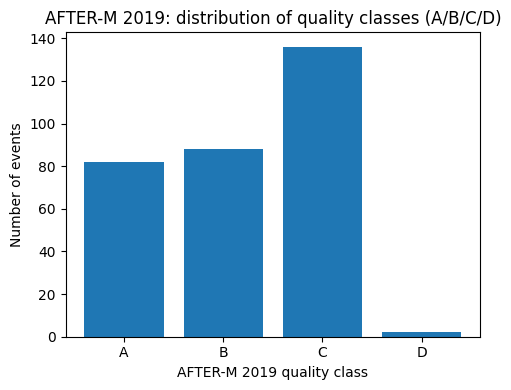

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
q_counts_sorted = q_counts.sort_values("quality")
ax.bar(q_counts_sorted["quality"], q_counts_sorted["count"])
ax.set_xlabel("AFTER-M 2019 quality class")
ax.set_ylabel("Number of events")
ax.set_title("AFTER-M 2019: distribution of quality classes (A/B/C/D)")
plt.tight_layout()

### **4. Contingency table: AFTER-M quality vs IZMIRAN match**

In [11]:
ct_quality_match = pd.crosstab(
    AFTER_M_2019["quality"],
    AFTER_M_2019["matched_izmiran"]
)
ct_quality_match.columns = ["AFTER-only", "AFTER∩IZMIRAN"]
ct_quality_match

,AFTER-only,AFTER∩IZMIRAN
quality,,
A,43,39
B,36,52
C,48,88
D,0,2


In [12]:
# Proporciones por clase:
ct_quality_match_prop = ct_quality_match.div(ct_quality_match.sum(axis=1), axis=0)
ct_quality_match_prop

,AFTER-only,AFTER∩IZMIRAN
quality,,
A,0.524390,0.475610
B,0.409091,0.590909
C,0.352941,0.647059
D,0.000000,1.000000


### **5. AFTER-M coverage of IZMIRAN 2019 and associated qualities**

In [13]:
n_izm_total = len(AFTER_izmiran_2019)
n_izm_captured = AFTER_izmiran_2019["in_sierra_M"].sum()  # keep original flag name

print("Total IZMIRAN 2019 events:", n_izm_total)
print("Captured by AFTER-M:", n_izm_captured, f"({n_izm_captured/n_izm_total:.3f})")

Total IZMIRAN 2019 events: 124
Captured by AFTER-M: 118 (0.952)


In [14]:
AFTER_izmiran_2019[AFTER_izmiran_2019["in_sierra_M"]]["sierra_qualities"].value_counts()

sierra_qualities
C        38
B,C      21
B        16
A        15
A,C      14
A,B      10
A,B,C     2
C,D       2
Name: count, dtype: int64

### **6. Distributions of drop_mean and A_complex_max (AFTER-only vs AFTER∩IZMIRAN)**

In [15]:
matched   = AFTER_M_2019[AFTER_M_2019["matched_izmiran"]]
unmatched = AFTER_M_2019[~AFTER_M_2019["matched_izmiran"]]

for col in ["drop_mean", "A_complex_max"]:
    print(f"\n=== {col} ===")
    print("AFTER∩IZMIRAN:")
    print(matched[col].describe())
    print("\nAFTER-only:")
    print(unmatched[col].describe())


=== drop_mean ===
AFTER∩IZMIRAN:
count    181.000000
mean       3.717224
std        1.171096
min        1.781473
25%        3.061817
50%        3.485268
75%        3.914931
max        8.791081
Name: drop_mean, dtype: float64

AFTER-only:
count    127.000000
mean       3.803344
std        1.142290
min        2.100977
25%        3.090362
50%        3.562767
75%        4.134362
max        8.681238
Name: drop_mean, dtype: float64

=== A_complex_max ===
AFTER∩IZMIRAN:
count    181.000000
mean       5.698159
std        3.945665
min        3.021830
25%        4.278327
50%        4.786822
75%        5.415852
max       31.105882
Name: A_complex_max, dtype: float64

AFTER-only:
count    127.000000
mean       6.217239
std        3.676378
min        3.429374
25%        4.435031
50%        4.958385
75%        5.867097
max       21.395388
Name: A_complex_max, dtype: float64


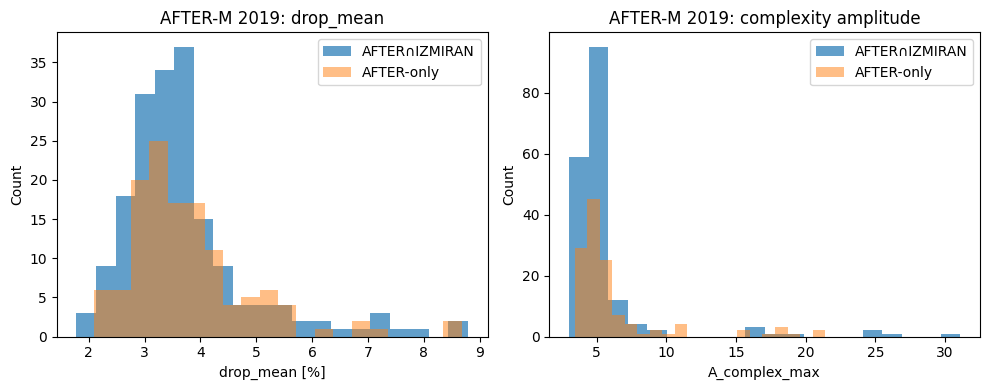

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(matched["drop_mean"].dropna(),   bins=20, alpha=0.7, label="AFTER∩IZMIRAN")
axes[0].hist(unmatched["drop_mean"].dropna(), bins=20, alpha=0.5, label="AFTER-only")
axes[0].set_xlabel("drop_mean [%]")
axes[0].set_ylabel("Count")
axes[0].set_title("AFTER-M 2019: drop_mean")
axes[0].legend()

axes[1].hist(matched["A_complex_max"].dropna(),   bins=20, alpha=0.7, label="AFTER∩IZMIRAN")
axes[1].hist(unmatched["A_complex_max"].dropna(), bins=20, alpha=0.5, label="AFTER-only")
axes[1].set_xlabel("A_complex_max")
axes[1].set_ylabel("Count")
axes[1].set_title("AFTER-M 2019: complexity amplitude")
axes[1].legend()

plt.tight_layout()

### **7. Station multiplicity in AFTER-M 2019**

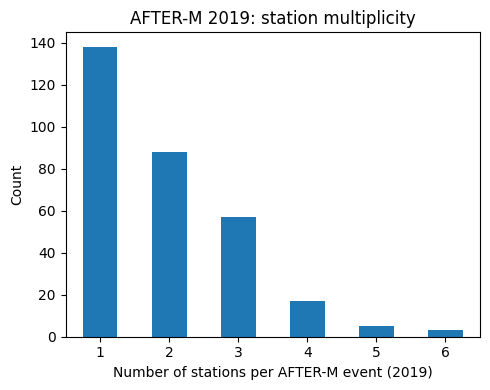

In [17]:
# Número de estaciones por coincidencia (AFTER-M 2019):
fig, ax = plt.subplots(figsize=(5, 4))
AFTER_M_2019["n_stations"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_xlabel("Number of stations per AFTER-M event (2019)")
ax.set_ylabel("Count")
ax.set_xticklabels(np.arange(1,7,1),rotation=0)
ax.set_title("AFTER-M 2019: station multiplicity")
plt.tight_layout()

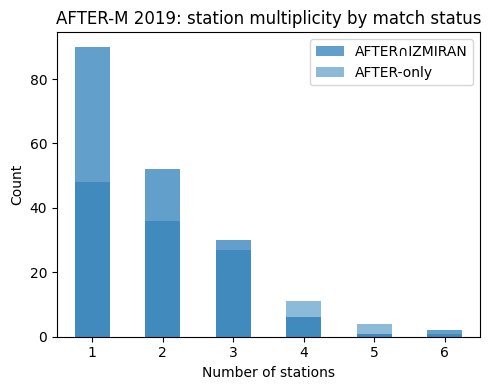

In [18]:
# Se puede comparar matched vs AFTER-only:
fig, ax = plt.subplots(figsize=(5, 4))
matched["n_stations"].value_counts().sort_index().plot(
    kind="bar", ax=ax, alpha=0.7, label="AFTER∩IZMIRAN"
)
unmatched["n_stations"].value_counts().sort_index().plot(
    kind="bar", ax=ax, alpha=0.5, label="AFTER-only"
)
ax.set_xlabel("Number of stations")
ax.set_ylabel("Count")
ax.set_title("AFTER-M 2019: station multiplicity by match status")
ax.set_xticklabels(np.arange(1,7,1),rotation=0)
ax.legend()
plt.tight_layout()

### **8. Quick summary tables ready to export**
#### **8.1 Quality counts + AFTER-only vs matched per class**

In [19]:
# Merge quality counts with contingency
quality_summary = ct_quality_match.copy()
quality_summary["total"] = quality_summary.sum(axis=1)
quality_summary["AFTER-only_frac"]   = quality_summary["AFTER-only"] / quality_summary["total"]
quality_summary["AFTER∩IZMIRAN_frac"] = quality_summary["AFTER∩IZMIRAN"] / quality_summary["total"]
quality_summary
quality_summary.to_csv("Results/AFTER_M_2019_quality_vs_IZMIRAN.csv")

#### **8.2 Simple AFTER vs IZMIRAN coverage table**

In [20]:
coverage_table = pd.DataFrame({
    "source": ["IZMIRAN_2019"],
    "n_events": [n_izm_total],
    "n_captured_by_AFTER_M": [n_izm_captured],
    "recall_AFTER_M": [n_izm_captured / n_izm_total]
})
coverage_table

,source,n_events,n_captured_by_AFTER_M,recall_AFTER_M
0,IZMIRAN_2019,124,118,0.951613


In [21]:
#####Results stats:

In [22]:
## Total size of the AFTER-M 2019 catalog and classes A/B/C/D

In [23]:
N_AFTER= len(AFTER_M_2019)
N_AFTER

308

In [24]:
q_counts = AFTER_M_2019["quality"].value_counts()
q_counts

quality
C    136
B     88
A     82
D      2
Name: count, dtype: int64

In [25]:
## IZMIRAN 2019 Coverage by AFTER-M

In [26]:
n_izm_total = len(AFTER_izmiran_2019)
n_izm_captured = AFTER_izmiran_2019["in_sierra_M"].sum()
n_izm_total, n_izm_captured, n_izm_captured / n_izm_total

(124, np.int64(118), np.float64(0.9516129032258065))

In [27]:
## Quality table × (AFTER-only vs AFTER∩IZMIRAN)

In [28]:
ct_quality_match = pd.crosstab(
    AFTER_M_2019["quality"],
    AFTER_M_2019["matched_izmiran"]
)
ct_quality_match.columns = ["AFTER-only", "AFTER∩IZMIRAN"]
ct_quality_match

,AFTER-only,AFTER∩IZMIRAN
quality,,
A,43,39
B,36,52
C,48,88
D,0,2


In [29]:
## Quality(s) associated with captured IZMIRAN events

In [30]:
AFTER_izmiran_2019[AFTER_izmiran_2019["in_sierra_M"]]["sierra_qualities"].value_counts()

sierra_qualities
C        38
B,C      21
B        16
A        15
A,C      14
A,B      10
A,B,C     2
C,D       2
Name: count, dtype: int64

In [31]:
## Simple statistics of drop_mean and A_complex_max

In [32]:
matched   = AFTER_M_2019[AFTER_M_2019["matched_izmiran"]]
unmatched = AFTER_M_2019[~AFTER_M_2019["matched_izmiran"]]

stats = {}
for col in ["drop_mean", "A_complex_max"]:
    stats[col] = {
        "matched_median":   matched[col].median(),
        "matched_q1":       matched[col].quantile(0.25),
        "matched_q3":       matched[col].quantile(0.75),
        "unmatched_median": unmatched[col].median(),
        "unmatched_q1":     unmatched[col].quantile(0.25),
        "unmatched_q3":     unmatched[col].quantile(0.75),
    }

stats

{'drop_mean': {'matched_median': np.float64(3.4852681398987913),
  'matched_q1': np.float64(3.0618172700628183),
  'matched_q3': np.float64(3.914930948555147),
  'unmatched_median': np.float64(3.5627671319364707),
  'unmatched_q1': np.float64(3.0903624047711156),
  'unmatched_q3': np.float64(4.134362400517247)},
 'A_complex_max': {'matched_median': np.float64(4.786821810677656),
  'matched_q1': np.float64(4.278326520598501),
  'matched_q3': np.float64(5.4158524426526995),
  'unmatched_median': np.float64(4.958384947376213),
  'unmatched_q1': np.float64(4.435030776582571),
  'unmatched_q3': np.float64(5.867097336212902)}}

In [33]:
## Summary by year/level

In [34]:
AFTER_year_level_summary[AFTER_year_level_summary["year"] == 2019]

,level,year,n_events,n_coinc_all,n_coinc_ge2,mean_stations_all,max_stations_all,mean_stations_ge2,max_stations_ge2
1,strict,2019,119,90,15,1.166667,2,2.000000,2
9,medium,2019,752,308,170,1.935065,6,2.694118,6
17,loose,2019,1788,382,329,3.141361,9,3.486322,9


In [35]:
# Select the columns you actually want in the table
cols = [
    "level", "year",
    "n_events",
    "n_coinc_all", "n_coinc_ge2",
    "mean_stations_all", "max_stations_all",
    "mean_stations_ge2", "max_stations_ge2"
]

tab_after_year_level = AFTER_year_level_summary[cols].copy()
tab_after_year_level


,level,year,n_events,n_coinc_all,n_coinc_ge2,mean_stations_all,max_stations_all,mean_stations_ge2,max_stations_ge2
0,strict,2018,118,89,10,1.112360,2,2.000000,2
1,strict,2019,119,90,15,1.166667,2,2.000000,2
2,strict,2020,105,85,3,1.035294,2,2.000000,2
3,strict,2021,294,139,24,1.194245,3,2.125000,3
4,strict,2022,146,107,20,1.205607,3,2.100000,3
5,strict,2023,191,135,22,1.200000,3,2.227273,3
6,strict,2024,240,156,50,1.371795,3,2.160000,3
7,strict,2025,193,118,31,1.347458,3,2.322581,3
8,medium,2018,819,328,192,2.009146,6,2.723958,6
9,medium,2019,752,308,170,1.935065,6,2.694118,6


In [36]:
tab_after_year_level.to_latex("tab_after_year_level.tex", index=False, float_format="%.2f")

In [37]:
N_AFTER = len(AFTER_M_2019)
q_counts = AFTER_M_2019["quality"].value_counts().sort_index()
q_frac = (q_counts / N_AFTER).round(3)

after_M_summary = pd.DataFrame({
    "quality": q_counts.index,
    "count": q_counts.values,
    "fraction": q_frac.values
})
after_M_summary


,quality,count,fraction
0,A,82,0.266
1,B,88,0.286
2,C,136,0.442
3,D,2,0.006


In [38]:
after_M_summary.to_latex("tab_after_M_2019_summary.tex", index=False, float_format="%.3f")

In [39]:
n_izm_total = len(AFTER_izmiran_2019)
n_izm_captured = AFTER_izmiran_2019["in_sierra_M"].sum()
recall = n_izm_captured / n_izm_total

coverage_table = pd.DataFrame({
    "catalog": ["IZMIRAN 2019"],
    "N_events": [n_izm_total],
    "N_captured_by_AFTER_M": [n_izm_captured],
    "recall": [recall]
})
coverage_table

,catalog,N_events,N_captured_by_AFTER_M,recall
0,IZMIRAN 2019,124,118,0.951613


In [40]:
coverage_table.to_latex("tab_after_vs_izmiran.tex", index=False, float_format="%.3f")

In [41]:
ct_quality_match = pd.crosstab(
    AFTER_M_2019["quality"],
    AFTER_M_2019["matched_izmiran"]
)
ct_quality_match.columns = ["AFTER-only", "AFTER∩IZMIRAN"]
ct_quality_match


,AFTER-only,AFTER∩IZMIRAN
quality,,
A,43,39
B,36,52
C,48,88
D,0,2


In [42]:
ct_quality_match.to_latex("tab_after_qualities_vs_izmiran.tex", float_format="%.0f")


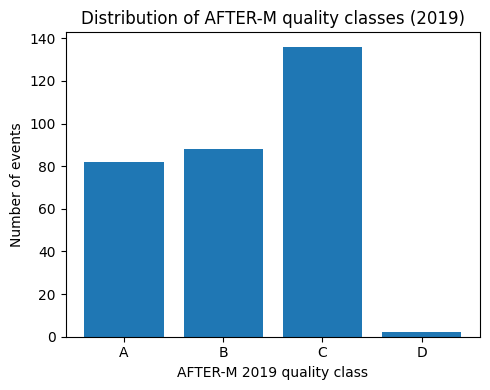

In [43]:
import matplotlib.pyplot as plt

q_counts = AFTER_M_2019["quality"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(q_counts.index, q_counts.values)
ax.set_xlabel("AFTER-M 2019 quality class")
ax.set_ylabel("Number of events")
ax.set_title("Distribution of AFTER-M quality classes (2019)")
plt.tight_layout()
plt.savefig("after_quality_bars_2019.png", dpi=300)
plt.show()

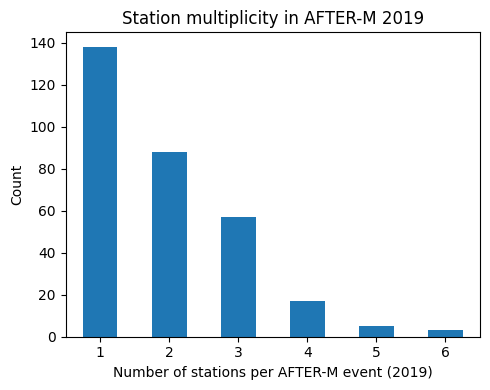

In [44]:
fig, ax = plt.subplots(figsize=(5, 4))
AFTER_M_2019["n_stations"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_xlabel("Number of stations per AFTER-M event (2019)")
plt.xticks(rotation=0)
ax.set_ylabel("Count")
ax.set_title("Station multiplicity in AFTER-M 2019")
plt.tight_layout()
plt.savefig("after_nstations_2019.png", dpi=300)
plt.show()

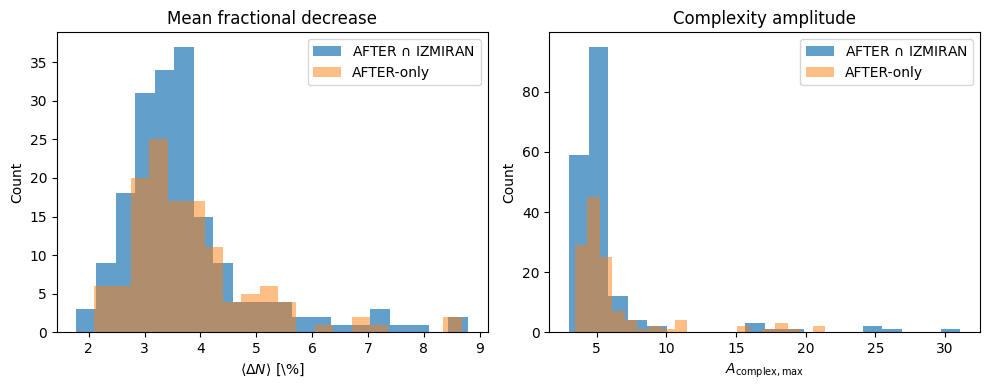

In [45]:
matched   = AFTER_M_2019[AFTER_M_2019["matched_izmiran"]]
unmatched = AFTER_M_2019[~AFTER_M_2019["matched_izmiran"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(matched["drop_mean"].dropna(),   bins=20, alpha=0.7, label=r"AFTER $\cap$ IZMIRAN")
axes[0].hist(unmatched["drop_mean"].dropna(), bins=20, alpha=0.5, label=r"AFTER-only")
axes[0].set_xlabel(r"$\langle \Delta N \rangle$ [\%]")
axes[0].set_ylabel("Count")
axes[0].set_title("Mean fractional decrease")
axes[0].legend()

axes[1].hist(matched["A_complex_max"].dropna(),   bins=20, alpha=0.7, label=r"AFTER $\cap$ IZMIRAN")
axes[1].hist(unmatched["A_complex_max"].dropna(), bins=20, alpha=0.5, label=r"AFTER-only")
axes[1].set_xlabel(r"$A_{\mathrm{complex,max}}$")
axes[1].set_ylabel("Count")
axes[1].set_title("Complexity amplitude")
axes[1].legend()

plt.tight_layout()
plt.savefig("after_histos_2019.png", dpi=300)
plt.show()

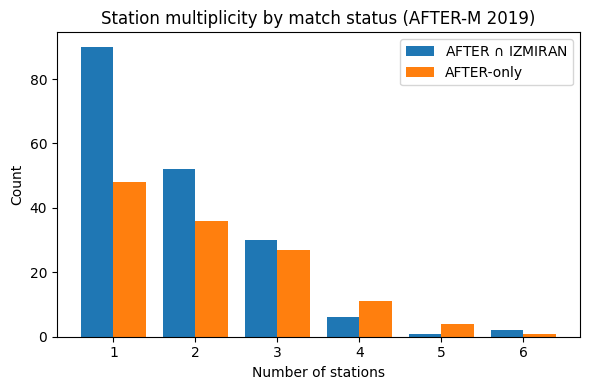

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))

matched_counts   = matched["n_stations"].value_counts().sort_index()
unmatched_counts = unmatched["n_stations"].value_counts().sort_index()

idx = sorted(set(matched_counts.index).union(unmatched_counts.index))
matched_vals   = [matched_counts.get(i, 0) for i in idx]
unmatched_vals = [unmatched_counts.get(i, 0) for i in idx]

width = 0.4
x = np.arange(len(idx))

ax.bar(x - width/2, matched_vals,   width=width, label=r"AFTER $\cap$ IZMIRAN")
ax.bar(x + width/2, unmatched_vals, width=width, label=r"AFTER-only")

ax.set_xticks(x)
ax.set_xticklabels(idx)
ax.set_xlabel("Number of stations")
ax.set_ylabel("Count")
ax.set_title("Station multiplicity by match status (AFTER-M 2019)")
ax.legend()

plt.tight_layout()
plt.savefig("after_nstations_match_2019.png", dpi=300)
plt.show()

## Case study

In [47]:
## Load the FD20 files… and clear the columns
import pandas as pd
import matplotlib.pyplot as plt

def load_fd_file(fname):
    # Semicolon-separated, with possible leading spaces in numbers
    df = pd.read_csv(fname, sep=";", engine="python")
    # Strip whitespace from column names
    df.columns = [c.strip() for c in df.columns]
    # Parse datetime and set index
    df["DATETIME"] = pd.to_datetime(df["DATETIME"])
    df.set_index("DATETIME", inplace=True)
    # Convert all station columns to numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

fd_2024 = load_fd_file("FD20240510.txt")
fd_2021 = load_fd_file("FD20211104.txt")

fd_2024.head(), fd_2021.head()


(                       CALM     ROME     BKSN     JUNG    JUNG1     DRBS  \
 DATETIME                                                                   
 2024-05-10 12:04:00  70.833  121.233  118.873  152.319  329.822  104.262   
 2024-05-10 12:06:00  69.300  122.484  118.289  151.236  329.675  100.471   
 2024-05-10 12:08:00  75.067  122.000  119.056  151.951  335.165  103.250   
 2024-05-10 12:10:00  69.592  123.575  114.811  152.877  333.299  104.432   
 2024-05-10 12:12:00  69.300  122.175  118.176  154.147  331.705  106.433   
 
                        NEWK    KIEL2     YKTK     KERG  ...     APTY    TXBY  \
 DATETIME                                                ...                    
 2024-05-10 12:04:00  91.075  168.855  200.933  211.203  ...  164.313  94.333   
 2024-05-10 12:06:00  89.110  168.846  202.733  208.986  ...  162.359  92.533   
 2024-05-10 12:08:00  91.205  168.581  203.733  206.321  ...  161.814  95.800   
 2024-05-10 12:10:00  88.885  162.096  204.000  209.56

In [48]:
## Calculate $\Delta N$ (% relative to a stable fund)
def compute_delta_percent(df, quiet_end, quiet_hours=2):
    """
    Compute fractional change (in %) relative to a quiet-time background.

    Parameters
    ----------
    df : DataFrame indexed by datetime, columns = stations (counts)
    quiet_end : pandas.Timestamp, end of quiet window
    quiet_hours : float, length of quiet window in hours

    Returns
    -------
    delta : DataFrame with same shape as df, in percent
    bg    : Series with background level per station
    """
    quiet_start = quiet_end - pd.Timedelta(hours=quiet_hours)
    quiet = df.loc[quiet_start:quiet_end]
    bg = quiet.mean()
    delta = 100.0 * (df / bg - 1.0)
    return delta, bg


In [49]:
stations_A = ["INVK","KERG","NEWK","OULU"]

# escoger una hora algo antes del onset, ajusta si hace falta
quiet_end_2024 = pd.Timestamp("2024-05-10 18:00:00")

delta_2024, bg_2024 = compute_delta_percent(fd_2024, quiet_end_2024, quiet_hours=2)

stations_B = ["INVK","NEWK","NAIN","THUL"]
quiet_end_2021 = pd.Timestamp("2021-11-03 18:00:00")

delta_2021, bg_2021 = compute_delta_percent(fd_2021, quiet_end_2021, quiet_hours=2)


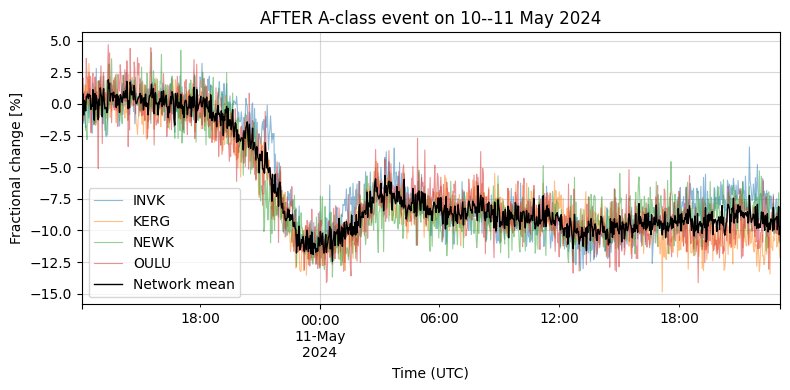

In [50]:
## Multi-station figures with net media
### A-class event: May 10–11, 2024
def plot_fd_case(delta, stations, title, outfile=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    # Curvas individuales (semi-transparentes)
    delta[stations].plot(ax=ax, alpha=0.5, linewidth=0.8, legend=False)
    # Media de la red en negro
    delta[stations].mean(axis=1).plot(ax=ax, color="black", linewidth=1, label="Network mean")
    ax.set_ylabel("Fractional change [%]")
    ax.set_xlabel("Time (UTC)")
    ax.set_title(title)
    plt.grid(alpha=0.5)
    ax.legend()
    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300)

plot_fd_case(
    delta_2024,
    stations_A,
    "AFTER A-class event on 10--11 May 2024",
    outfile="AFTER_case_A_20240510.png"
)


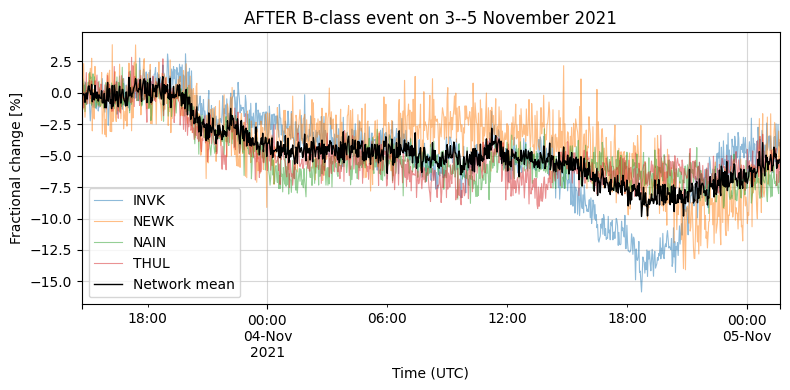

In [51]:
plot_fd_case(
    delta_2021,
    stations_B,
    "AFTER B-class event on 3--5 November 2021",
    outfile="AFTER_case_B_20211104.png"
)


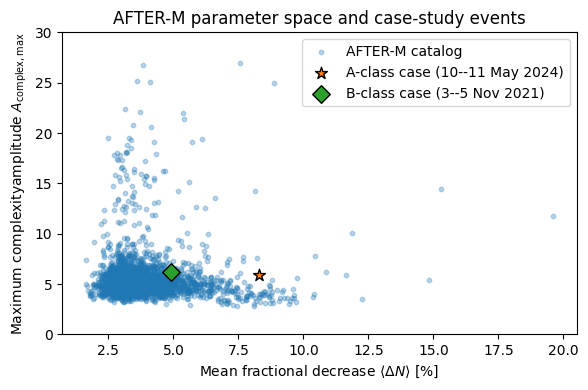

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

AFTER_M_all=pd.read_csv("Results/AFTER_M_full_catalog.csv")
AFTER_M_all["repr_time"]=pd.to_datetime(AFTER_M_all["repr_time"])
# Timestamps of the two case-study events
t_A = pd.Timestamp("2024-05-10 22:18:00")
t_B = pd.Timestamp("2021-11-04 05:29:00")

case_A = AFTER_M_all.loc[AFTER_M_all["repr_time"] == t_A].iloc[0]
case_B = AFTER_M_all.loc[AFTER_M_all["repr_time"] == t_B].iloc[0]

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter of all AFTER-M events (semi-transparent)
ax.scatter(
    AFTER_M_all["drop_mean"],
    AFTER_M_all["A_complex_max"],
    s=10, alpha=0.3, label="AFTER-M catalog"
)

# Highlight A-class case
ax.scatter(
    case_A["drop_mean"], case_A["A_complex_max"],
    s=80, marker="*", edgecolor="k", linewidth=1.0,
    label="A-class case (10--11 May 2024)"
)

# Highlight B-class case
ax.scatter(
    case_B["drop_mean"], case_B["A_complex_max"],
    s=80, marker="D", edgecolor="k", linewidth=1.0,
    label="B-class case (3--5 Nov 2021)"
)

ax.set_xlabel(r"Mean fractional decrease $\langle \Delta N \rangle$ [%]")
ax.set_ylabel(r"Maximum complexity"+r"amplitude $A_{\mathrm{complex,max}}$")
ax.set_title("AFTER-M parameter space and case-study events")
ax.set_ylim(0,30)
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("AFTER_param_plane_cases.png", dpi=300)
plt.show()